In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 49.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 24.6 MB/s eta 0:00:00


In [2]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 59.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 79.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.0 MB/s eta 0:00:00


In [3]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

2024-01-14 11:31:26.844674: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define the connection between Input data and Label

In [5]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [6]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [7]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = "/mnt/train_data.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/train_data.tfrecord
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


2024-01-14 11:31:30.249014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 11:31:30.306495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 11:31:30.306729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [8]:
print(train_dataset)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [9]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = "/mnt/validation_data.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/validation_data.tfrecord


In [10]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [11]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

config.json: 100%|█████████████████████████████████████████████████████████████████████| 483/483 [00:00<00:00, 1.49MB/s]

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [12]:
# Adding the layer for fine tuning on BERT

In [13]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

model.safetensors: 100%|██████████████████████████████████████████████████████████████| 268M/268M [00:02<00:00, 106MB/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and ar

In [14]:
# Set up the custom classifier model

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

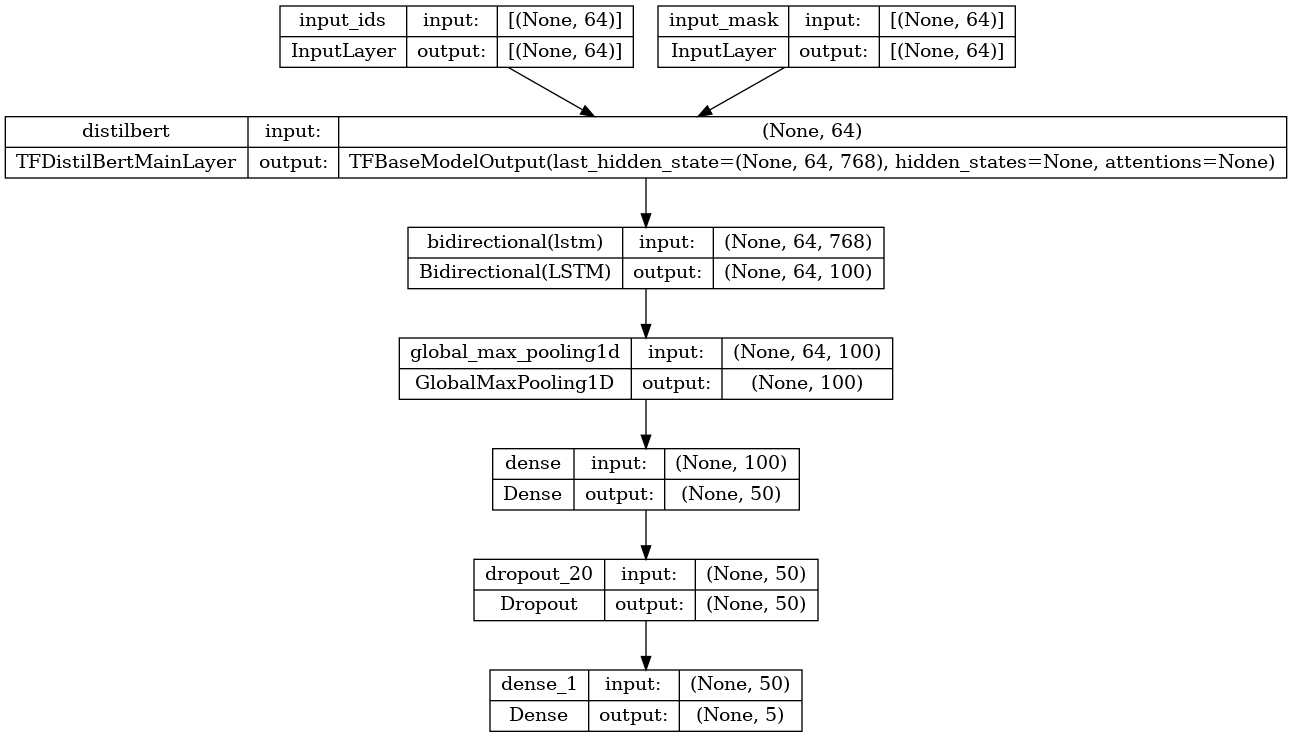

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [17]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [18]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

2024-01-14 11:32:58.404025: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-14 11:32:58.405162: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-14 11:33:07.930

1/1 [==============================] - ETA: 0s - loss: 1.5868 - accuracy: 0.2500

2024-01-14 11:33:09.610225: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-14 11:33:09.610651: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 13s 13s/step - loss: 1.5868 - accuracy: 0.2500 - val_loss: 1.5253 - val_accuracy: 0.5000


In [19]:
epochs = 256
steps_per_epoch = 512
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [20]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/256
512/512 [==============================] - 200s 389ms/step - loss: 1.6048 - accuracy: 0.2393 - val_loss: 1.5418 - val_accuracy: 0.3281
Epoch 2/256
512/512 [==============================] - 202s 395ms/step - loss: 1.5367 - accuracy: 0.3135 - val_loss: 1.4701 - val_accuracy: 0.4141
Epoch 3/256
512/512 [==============================] - 199s 388ms/step - loss: 1.4625 - accuracy: 0.3633 - val_loss: 1.4005 - val_accuracy: 0.4062
Epoch 4/256
512/512 [==============================] - 200s 391ms/step - loss: 1.3988 - accuracy: 0.3948 - val_loss: 1.3312 - val_accuracy: 0.4297
Epoch 5/256
512/512 [==============================] - 202s 394ms/step - loss: 1.3281 - accuracy: 0.4150 - val_loss: 1.3266 - val_accuracy: 0.4453
Epoch 6/256
512/512 [==============================] - 199s 389ms/step - loss: 1.3232 - accuracy: 0.4111 - val_loss: 1.2700 - val_accuracy: 0.4336
Epoch 7/256
512/512 [==============================] - 201s 392ms/step - loss: 1.2914 - accuracy: 0.4314 - val_loss: 1

512/512 [==============================] - 195s 380ms/step - loss: 1.1690 - accuracy: 0.4939 - val_loss: 1.1712 - val_accuracy: 0.4883
Epoch 57/256
512/512 [==============================] - 196s 382ms/step - loss: 1.1543 - accuracy: 0.4880 - val_loss: 1.1683 - val_accuracy: 0.4648
Epoch 58/256
512/512 [==============================] - 196s 383ms/step - loss: 1.1608 - accuracy: 0.4856 - val_loss: 1.1668 - val_accuracy: 0.4883
Epoch 59/256
512/512 [==============================] - 194s 378ms/step - loss: 1.1608 - accuracy: 0.4978 - val_loss: 1.1742 - val_accuracy: 0.4766
Epoch 60/256
512/512 [==============================] - 198s 386ms/step - loss: 1.1547 - accuracy: 0.4937 - val_loss: 1.1700 - val_accuracy: 0.4805
Epoch 61/256
512/512 [==============================] - 196s 383ms/step - loss: 1.1596 - accuracy: 0.4932 - val_loss: 1.1638 - val_accuracy: 0.4688
Epoch 62/256
512/512 [==============================] - 193s 377ms/step - loss: 1.1641 - accuracy: 0.4858 - val_loss: 1.1686 

512/512 [==============================] - 196s 384ms/step - loss: 1.1460 - accuracy: 0.5134 - val_loss: 1.1233 - val_accuracy: 0.5078
Epoch 112/256
512/512 [==============================] - 194s 379ms/step - loss: 1.1323 - accuracy: 0.5032 - val_loss: 1.1486 - val_accuracy: 0.4688
Epoch 113/256
512/512 [==============================] - 197s 385ms/step - loss: 1.1098 - accuracy: 0.5176 - val_loss: 1.1176 - val_accuracy: 0.5234
Epoch 114/256
512/512 [==============================] - 195s 380ms/step - loss: 1.1335 - accuracy: 0.5044 - val_loss: 1.1214 - val_accuracy: 0.5469
Epoch 115/256
512/512 [==============================] - 194s 379ms/step - loss: 1.1359 - accuracy: 0.5020 - val_loss: 1.1155 - val_accuracy: 0.5156
Epoch 116/256
512/512 [==============================] - 196s 382ms/step - loss: 1.1428 - accuracy: 0.5051 - val_loss: 1.1257 - val_accuracy: 0.4961
Epoch 117/256
512/512 [==============================] - 194s 378ms/step - loss: 1.1204 - accuracy: 0.5015 - val_loss: 1

512/512 [==============================] - 199s 388ms/step - loss: 1.1047 - accuracy: 0.5129 - val_loss: 1.1016 - val_accuracy: 0.5117
Epoch 167/256
512/512 [==============================] - 198s 386ms/step - loss: 1.1179 - accuracy: 0.5181 - val_loss: 1.1036 - val_accuracy: 0.5195
Epoch 168/256
512/512 [==============================] - 196s 383ms/step - loss: 1.1014 - accuracy: 0.5181 - val_loss: 1.0989 - val_accuracy: 0.5273
Epoch 169/256
512/512 [==============================] - 199s 388ms/step - loss: 1.1257 - accuracy: 0.5002 - val_loss: 1.1007 - val_accuracy: 0.5117
Epoch 170/256
512/512 [==============================] - 197s 384ms/step - loss: 1.0831 - accuracy: 0.5266 - val_loss: 1.0964 - val_accuracy: 0.5156
Epoch 171/256
512/512 [==============================] - 199s 388ms/step - loss: 1.0946 - accuracy: 0.5173 - val_loss: 1.1086 - val_accuracy: 0.5117
Epoch 172/256
512/512 [==============================] - 197s 385ms/step - loss: 1.1108 - accuracy: 0.5205 - val_loss: 1

512/512 [==============================] - 198s 387ms/step - loss: 1.0896 - accuracy: 0.5186 - val_loss: 1.0958 - val_accuracy: 0.5078
Epoch 222/256
512/512 [==============================] - 196s 384ms/step - loss: 1.0908 - accuracy: 0.5215 - val_loss: 1.0915 - val_accuracy: 0.5430
Epoch 223/256
512/512 [==============================] - 199s 388ms/step - loss: 1.0956 - accuracy: 0.5132 - val_loss: 1.0976 - val_accuracy: 0.5195
Epoch 224/256
512/512 [==============================] - 198s 387ms/step - loss: 1.0939 - accuracy: 0.5134 - val_loss: 1.0901 - val_accuracy: 0.5391
Epoch 225/256
512/512 [==============================] - 200s 390ms/step - loss: 1.0600 - accuracy: 0.5449 - val_loss: 1.0827 - val_accuracy: 0.5352
Epoch 226/256
512/512 [==============================] - 201s 392ms/step - loss: 1.0940 - accuracy: 0.5164 - val_loss: 1.0830 - val_accuracy: 0.5117
Epoch 227/256
512/512 [==============================] - 200s 391ms/step - loss: 1.1016 - accuracy: 0.5178 - val_loss: 1

In [21]:
print(history.history)

{'loss': [1.6048336029052734, 1.5366772413253784, 1.4625357389450073, 1.3987500667572021, 1.3280514478683472, 1.3232420682907104, 1.2913539409637451, 1.2987799644470215, 1.3030401468276978, 1.275808572769165, 1.276410698890686, 1.2649024724960327, 1.2264832258224487, 1.2383559942245483, 1.2317051887512207, 1.2482105493545532, 1.239807367324829, 1.227082371711731, 1.2226362228393555, 1.235274314880371, 1.2376794815063477, 1.2182117700576782, 1.2054709196090698, 1.215003252029419, 1.219797968864441, 1.2069392204284668, 1.210744857788086, 1.2088464498519897, 1.215495228767395, 1.2045987844467163, 1.2065365314483643, 1.2015632390975952, 1.1823968887329102, 1.1832588911056519, 1.2003463506698608, 1.1865431070327759, 1.1865077018737793, 1.1936216354370117, 1.1875174045562744, 1.19121253490448, 1.185779094696045, 1.1823517084121704, 1.187535047531128, 1.1695976257324219, 1.1758778095245361, 1.1722384691238403, 1.1636325120925903, 1.182317852973938, 1.1663775444030762, 1.1792832612991333, 1.17

In [22]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

tokenizer_config.json: 100%|█████████████████████████████████████████████████████████| 28.0/28.0 [00:00<00:00, 61.2kB/s]
vocab.txt: 100%|██████████████████████████████████████████████████████████████████████| 232k/232k [00:00<00:00, 528kB/s]
tokenizer.json: 100%|████████████████████████████████████████████████████████████████| 466k/466k [00:00<00:00, 5.53MB/s]


In [23]:
# Adhoc predict

In [24]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.8344945311546326}

In [25]:
predict("This is cool.")

1/1 [==============================] - 0s 57ms/step


{'label': 5, 'socre': 0.45766350626945496}

In [26]:
predict("I don't like this.")

1/1 [==============================] - 0s 57ms/step


{'label': 1, 'socre': 0.5914115309715271}

In [27]:
predict("I might buy it again.")

1/1 [==============================] - 0s 56ms/step


{'label': 2, 'socre': 0.3141213357448578}

In [28]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 65ms/step


{'label': 3, 'socre': 0.5854071378707886}

In [29]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

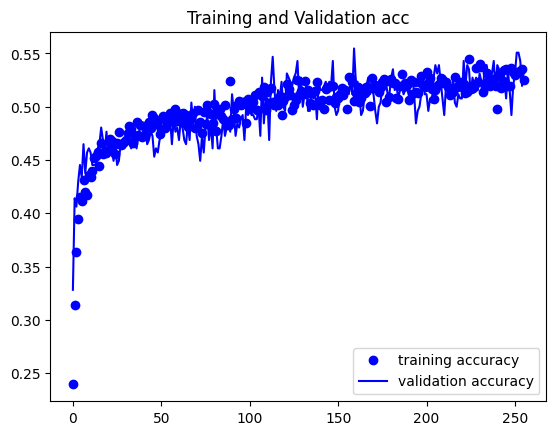

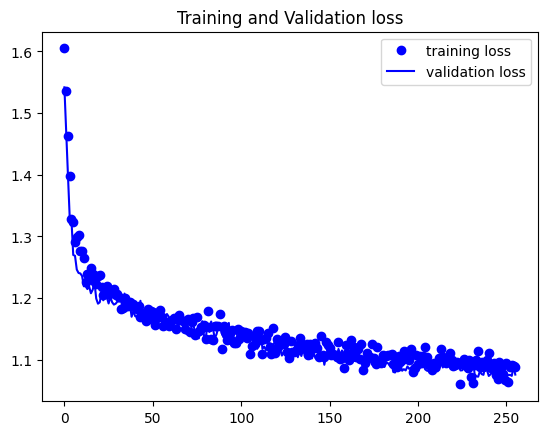

In [30]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [31]:
model.save('/mnt/tensorflow/',save_format='tf')

2024-01-15 01:49:40.227056: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-15 01:49:40.309344: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-15 01:49:40.332854: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and sh

2024-01-15 01:49:44.583558: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-15 01:49:44.594575: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-15 01:49:44.605814: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-01-15 

INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


In [32]:
!ls /mnt/tensorflow

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [33]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>